# Function Approximation in 1D

In this tutorial we are going to work through a full example of defining and training a neural network. We will use a shallow ReLU network to approximate a function in 1D.


In [1]:
# standard libraries
import math, os, time
import numpy as np

# plotting
import matplotlib.pyplot as plt

# progress bars
from tqdm.notebook import trange, tqdm

# PyTorch
import torch

In [2]:
# Handy line for using a CUDA device if available but default to the CPU if not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Creating the Dataset

To train a neural network we need samples from our target function. We will simply sample our function uniformly on $[0,1]$.

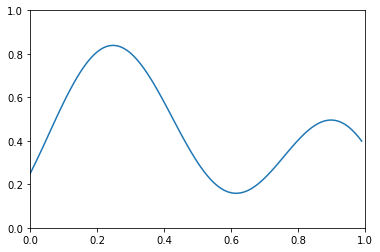

In [3]:
X = torch.arange(0., 1., step=0.01, device=device)
Y = 0.6 * torch.sin(6*X) * torch.sin(3*X+1) + 0.25

plt.plot(X.cpu(), Y.cpu(), label="function") # can only plot data on the CPU
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()

Minor technicality: `X` and `Y` have shape `[100]`, meaning when we access an element we get a scalar (i.e. tensor with no shape). Most PyTorch operations require tensors to have shape to operate on. We can fix this simply by using `.unsqueeuze(-1)`: this will add a dimension of size 1 to a tensor. The argument specifies where the dimension is to be inserted, -1 means at the end.

Dimensions of size 1 can also be removed easily with `.squeeze()`, none of these operations change anything about the contents of the tensors, they just change their interpretation.

In [4]:
print(X.shape)
print(X[0].shape) # empty shape => scalar

X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

print(X.shape)
print(X[0].shape) # 1D tensor with 1 element

torch.Size([100])
torch.Size([])
torch.Size([100, 1])
torch.Size([1])


While we could work with the `X` and `Y` tensors directly, PyTorch provides a lot of utilities for working with data in the `torch.utils.data` namespace. Using these utilities makes it easier to do things like creating random batches, loading data on demand, augmenting data, splitting data into training and testing data etc.

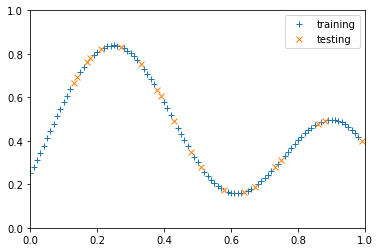

In [5]:
# Create a dataset from existing tensors
dataset = torch.utils.data.TensorDataset(X, Y)

# lets follow best practices and split into training and testing data
# we will split the dataset 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# now to do the actual splitting
# using generator=torch.manual_seed(0) fixes the RNG so we get a reproducable split
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.manual_seed(0))


plt.plot(train_data[:][0].cpu().squeeze(), train_data[:][1].cpu().squeeze(), '+', label="training")
plt.plot(test_data[:][0].cpu().squeeze(), test_data[:][1].cpu().squeeze(), 'x', label="testing")
plt.legend()
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()

Now that we have our data sorted, we can move on to building a model.

## Defining a Neural Network

The basic building blocks of NNs in PyTorch are _modules_, more specifically subclasses of `torch.nn.Module`. To define a network we create instances of the modules we want and indicated how we want them connected. To construct a shallow ReLU network we need 3 modules:
- `torch.nn.Linear` : linear and affine transform of its inputs,
- `torch.nn.ReLU` : element-wise ReLU,
- `torch.nn.Sequential` : connects its submodules in a sequential or feedforward fashion.
Now lets put our network together.

In [6]:
hidden = 32 # how many hidden units we want

network = torch.nn.Sequential(
    torch.nn.Linear(1, hidden), # = x A^T + b
    torch.nn.ReLU(), # = ReLU(x A^T + b)
    torch.nn.Linear(hidden, 1, bias=False), # = ReLU(x A^T + b) C^T
)
# to get just a linear transform we disable the bias term in Linear with bias=False
# also note the odd x A^T + b convention rather than our usual Ax + b

# lets move our network to our device of choice, this happens in the same manner as with tensors
network = network.to(device)

This mathches exactly the definition of a shallow ReLU network we saw before:
$$
    network(x) = \sum_{i=1}^{hidden} c_i \sigma (a_i x + b_i)
$$

We can inspect various aspects of the network we created.

In [7]:
print(network) # the whole network: consists of the 3 modules executed in sequence
print()

print(network[0]) # inspect the first module
print()

print(network[0].weight) # inspect the linear weights of the first linear module (i.e. A)
print(network[0].bias) # the bias tensor (i.e. b)

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=False)
)

Linear(in_features=1, out_features=32, bias=True)

Parameter containing:
tensor([[-0.5758],
        [ 0.9407],
        [ 0.6738],
        [-0.4360],
        [-0.2517],
        [-0.9526],
        [-0.0180],
        [-0.7531],
        [-0.7714],
        [-0.0551],
        [ 0.1501],
        [-0.4095],
        [ 0.5934],
        [-0.6085],
        [ 0.9074],
        [ 0.6853],
        [-0.8433],
        [-0.2489],
        [ 0.0451],
        [ 0.1459],
        [ 0.2372],
        [ 0.3924],
        [ 0.0599],
        [-0.4879],
        [ 0.4732],
        [-0.9592],
        [-0.5927],
        [-0.2503],
        [-0.4871],
        [-0.3498],
        [-0.8196],
        [-0.2127]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.2138, -0.6515, -0.0513,  0.7159, -0.1028,  0.0278, -0.0863,  0.2024,
         0.6358,  0.9472,  0.6351, 

You can see that each module has already initialized its parameters, we will go with these initial values for the moment. Observe that instead of just printing the tensor, each line starts with `Parameter containing:`. Parameters are stored as a `torch.Tensor` wrapped in a `torch.nn.parameter.Parameter`, this wrapper does nothing other than flagging the tensor as being used as a parameter. Note that each of the parameter tensors has been placed on our chosen `device`. Also note the new `requires_grad=True` flag, this indicates to PyTorch that during evaluation of the network it has to collect data to allow it to compute the gradient with respect to these tensors.

Lets see what the network outputs at this stage. Since we just want to evaluate the network (inferencing in DL parlace) we do not need the extra work that is required to compute gradients, to temporarily turn gradient computation off we can use the `torch.no_grad` context manager.

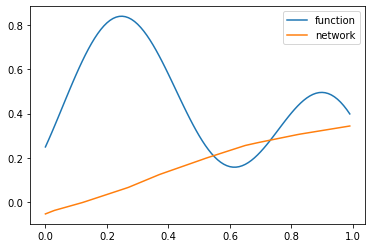

In [8]:
with torch.no_grad():
    # in this scope, gradient computation is disabled
    # lets feed in our range of x-coordinates and see what comes out
    Ypred = network(X)
    
plt.plot(X.cpu(), Y.cpu(), '-', label="function") # can only plot data on the CPU
plt.plot(X.cpu(), Ypred.cpu(), '-', label="network")
plt.legend()
plt.show()

Not great, but we did just randomly initialize the network. Lets see how we can improve.

## Training

We are going to use Stochastic Gradient Descent to fit our parameters. To do SGD we need to draw random batches from our training data, `torch.utils.data.DataLoader` does exactly that. We also need to make some choices now about how many times we want to go through our dataset (epochs), how big our batches are going to be and what learning rate we want.

First we provide a way to reset the network i.e. reinitialize its parameters according to some default distribution.

In [9]:
# reset all the parameters of a network
# we iterate through all the submodules and if a submodule provides a reset_parameters function we call it
for m in network.children():
   if hasattr(m, 'reset_parameters'):
       m.reset_parameters()

Second we setup the training process. We specify the number of epochs, the batch size and the learning rate. We also build a `DataLoader` to provide us with batches of data and attach an SGD optimizer to our networks parameters.

In [10]:
EPOCHS = 1000
BATCH_SIZE = 8
LEARNING_RATE = 0.005

# A DataLoader will feed us random (shuffled) batches
loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# An optimizer will modify our network's parameters
# we use the SGD optimizer and let it know what parameters it has to consider
# we also specify the learning rate
optimizer = torch.optim.SGD(network.parameters(), lr=LEARNING_RATE)

from IPython.display import clear_output # for animating the plot

Finally we can begin training: in each epoch we loop through all the batches the loader provides and:
1) Calculate the loss of the batch,
2) Calculate the gradient of the loss with respect to the parameters,
3) Modify the parameters with the gradient.

Every few epochs we evaluate the network along the whole interval and plot the result to see how we are progressing. You can execute the following cell as many times as you like to keep training the network.

⚠ Sometimes the random initialization of parameters will put the network in a bad local minima it cannot escape from. If after a few thousand epochs not much has happened you should reset the network with the cell above.

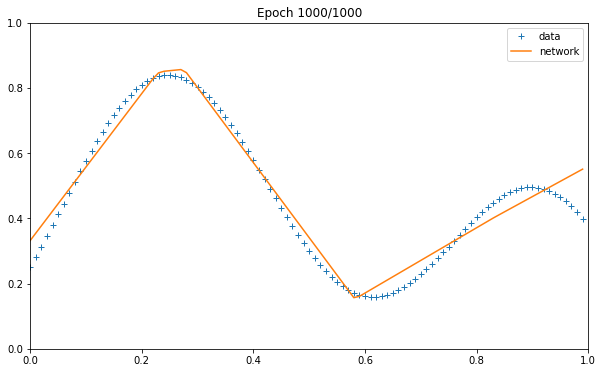

In [11]:
for epoch in range(1, EPOCHS+1):
    
    network.train() # Switch model to training mode (gradients are calculated)
    
    for x, y in iter(loader):
        optimizer.zero_grad() # zero out the gradients
        prediction = network(x) # evaluate the batch data
        loss = (y - prediction).pow(2).sum() # calculate the loss of the actual output vs. the desired output
        loss.backward() # calculate the gradient of the loss function with respect to the parameters via backpropagation
        optimizer.step() # now that the gradients are calculated the optimizer can modify the parameters
    
    network.eval() # Switch model to evaluation mode (no gradients are calculated)
    Ypred = network(X) # network's prediction for the whole interval
    
    # Plot every few epochs
    if epoch % 20 == 0 or epoch == EPOCHS:
        clear_output(wait=True)
        plt.figure(figsize=[10, 6])
        plt.title(f"Epoch {epoch}/{EPOCHS}")
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.plot(X.cpu(), Y.cpu(), '+',label="data")
        plt.plot(X.cpu(), Ypred.detach().cpu(), '-', label="network") # I'll explain .detach() below
        plt.legend()
        plt.show()

### Technical aside: Detaching and `requires_grad`

When we perform operations with tensors PyTorch does a lot of work in the background to enable it to calculate gradients. We already saw the use of the context manager `torch.no_grad` to suppress this behaviour. Using `.detach()` on a tensor is an alternative, it provides a reference to the same tensor but flagged as not requiring gradient calculations. PyTorch tracks which tensors are going to need gradients calculated with the `requires_grad` flag. If you looked carefully you could see the `requires_grad=True` property being present when we were exploring the parameters of our network a few cells back.

All tensors that are the result of computations with tensors that have `requires_grad=True` will also have `requires_grad=True`. Our ouput tensor `Ypred` was calculated using the parameters in the model and so has `requires_grad=True`. When we pass it to `plt.plot` PyTorch will try the differentiate that function and fail. By detaching `Ypred` we let the system know we do not want that to happen.

True
False


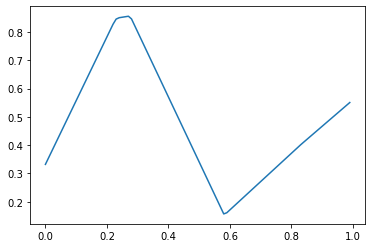

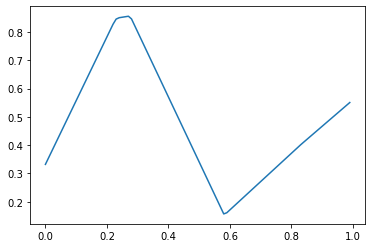

In [12]:
print(Ypred.requires_grad)
print(Ypred.detach().requires_grad)

# These both do the same thing
# removing either the context manager or the .detach() will cause an error
with torch.no_grad():
    plt.plot(X.cpu(), Ypred.cpu())
    plt.show()
    
plt.plot(X.cpu(), Ypred.detach().cpu())
plt.show()

## Inspecting the Result

Lets take a closer look at the network as it stands now. Let us look at the inflection points of the network's output.

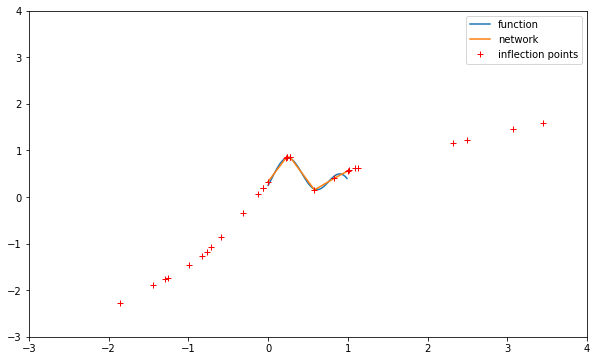

In [13]:
# again we use detach liberaly since we do not want these calculations to be differentiated
Xinflection = - network[0].bias.detach() / network[0].weight.detach().squeeze()
Yinflection = network(Xinflection.unsqueeze(-1)).squeeze().detach()

plt.figure(figsize=[10, 6])
plt.xlim(-3,4)
plt.ylim(-3,4)
plt.plot(X.cpu(), Y.cpu(), '-',label="function")
plt.plot(X.cpu(), Ypred.detach().cpu(), '-', label="network")
plt.plot(Xinflection.cpu(), Yinflection.cpu(), 'r+', label="inflection points")
plt.legend()
plt.show()

That is less than optimal, most inflection points are outside of our range of interest, wasting a lot of the capacity of the network. Lets train some more with the inflection points visualized to see how they behave.

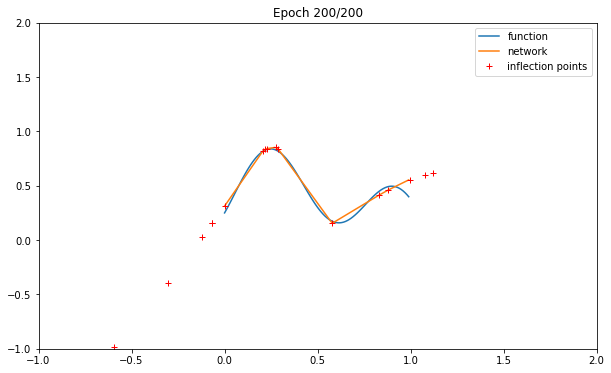

In [14]:
EPOCHS=200

for epoch in range(1, EPOCHS+1):
    
    network.train() # Switch model to training mode (gradients are calculated)
    
    for x, y in iter(loader):
        optimizer.zero_grad() # zero out the gradients
        prediction = network(x) # evaluate the batch data
        loss = (y - prediction).pow(2).sum() # calculate the loss of the actual output vs. the desired output
        loss.backward() # calculate the gradient of the loss function with respect to the parameters via backpropagation
        optimizer.step() # now that the gradients are calculated the optimizer can modify the parameters
    
    network.eval() # Switch model to evaluation mode (no gradients are calculated)
    Ypred = network(X) # network's prediction for the whole interval
    
    # Plot every few epochs
    if epoch % 20 == 0 or epoch == EPOCHS:
        clear_output(wait=True)
        plt.figure(figsize=[10, 6])
        plt.title(f"Epoch {epoch}/{EPOCHS}")
        plt.xlim(-1,2)
        plt.ylim(-1,2)
        plt.plot(X.cpu(), Y.cpu(), '-', label="function")
        plt.plot(X.cpu(), Ypred.detach().cpu(), '-', label="network") # I'll explain .detach() below
        
        Xinflection = - network[0].bias.detach() / network[0].weight.detach().squeeze()
        Yinflection = network(Xinflection.unsqueeze(-1)).squeeze().detach()
        plt.plot(Xinflection.cpu(), Yinflection.cpu(), 'r+', label="inflection points")
        
        plt.legend()
        plt.show()

The inflection points are barely moving. So we cannot rely on further training to improve the situation. Perhaps that is not too suprising, we just accepted the default random initialization of our parameters and hoped for the best. Lets see how we can improve.

## Initialization

The location of the inflection points is determined by the first affine transform:
$$
ax+b=0 \Rightarrow x = -\frac{b}{a},
$$
assuming $a \neq 0$. So lets initialize the $a$'s and $b$'s to cover our domain. To make it easy we can set all $a$'s to $1$ and space the $b$'s equidistant between $-1$ and $0$.

There are three ways to manually set the values of existing parameter tensors.

In [15]:
"""
We set the a's first.
Recall that parameters are tensors wrapped in a torch.nn.parameter.Parameter
to access the tensor itself we call .data on the Parameter.
We call an in-place method of the tensor, in-place means it will modify the existing tensor and not build a new one or generate a copy.
You can identify in-place methods by their trailing underscore.
The following line will set all values of the weight parameters to 1.0.
"""
network[0].weight.data.fill_(1.0)

"""
The b's are next.
We can use all of the tensor creation functions we already saw to initialize an existing tensor by specifying the `out` argument.
When `out` is specified the function will not generate a new tensor but fill in the `out` tensor.
The following line will fill the b's with values from the range -1 to 0.
"""
torch.arange(start=-1.0, end=0.0, step=1.0/hidden, out=network[0].bias.data)


"""
The `torch.nn.init` namespace contains a set of common stochastic initialization methods.
These function work directly on `Parameter` object so no need to use `.data`.
The following line will initialize the weight of the final linear combination with values drawn uniformly from [-1,1].
Note the trailing underscore indicating this is also an in-place function.
We will fix the RNG seed again for reproducability.
"""
torch.manual_seed(0)
torch.nn.init.uniform_(network[2].weight, a=-1.0, b=1.0)

Parameter containing:
tensor([[-0.2019,  0.0334, -0.9501,  0.8802,  0.8917,  0.5935, -0.1700,  0.6405,
         -0.5419,  0.8192, -0.7633, -0.8496, -0.1816,  0.9201, -0.5814, -0.6121,
          0.7819, -0.1227, -0.2860,  0.0907,  0.6598, -0.5801,  0.5368, -0.1420,
         -0.5767,  0.3211, -0.6693, -0.1500,  0.9853,  0.3928, -0.5056,  0.4056]],
       device='cuda:0', requires_grad=True)

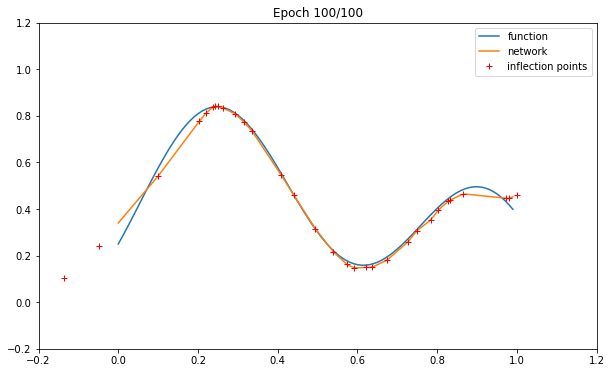

In [16]:
EPOCHS=100

for epoch in range(1, EPOCHS+1):
    
    network.train() # Switch model to training mode (gradients are calculated)
    
    for x, y in iter(loader):
        optimizer.zero_grad() # zero out the gradients
        prediction = network(x) # evaluate the batch data
        loss = (y - prediction).pow(2).sum() # calculate the loss of the actual output vs. the desired output
        loss.backward() # calculate the gradient of the loss function with respect to the parameters via backpropagation
        optimizer.step() # now that the gradients are calculated the optimizer can modify the parameters
    
    network.eval() # Switch model to evaluation mode (no gradients are calculated)
    Ypred = network(X) # network's prediction for the whole interval
    
    # Plot every few epochs
    if epoch % 2 == 0 or epoch == EPOCHS:
        clear_output(wait=True)
        plt.figure(figsize=[10, 6])
        plt.title(f"Epoch {epoch}/{EPOCHS}")
        plt.xlim(-0.2,1.2)
        plt.ylim(-0.2,1.2)
        plt.plot(X.cpu(), Y.cpu(), '-', label="function")
        plt.plot(X.cpu(), Ypred.detach().cpu(), '-', label="network") # I'll explain .detach() below
        
        Xinflection = - network[0].bias.detach() / network[0].weight.detach().squeeze()
        Yinflection = network(Xinflection.unsqueeze(-1)).squeeze().detach()
        plt.plot(Xinflection.cpu(), Yinflection.cpu(), 'r+', label="inflection points")
        
        plt.legend()
        plt.show()

A much better result than before. This example shows the importance of initialization, the training process does not magically produce a good optimization of the network.